In [2]:
import matplotlib.pyplot as plt
import time
import numpy as np
from numpy import pi

from qutip import *
from qutip.control import *
from qutip.qip.operations import rx
from qutip.qip.operations import ry
from qutip.qip.operations import rz

from qutip.control.grape import plot_grape_control_fields, _overlap
from qutip.control.cy_grape import cy_overlap
from qutip.control.grape import cy_grape_unitary, grape_unitary_adaptive

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from dataclasses import dataclass
from typing import List, Tuple, Sequence

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objs as go
import plotly.express as px

from scipy.constants import physical_constants, h

from qutip import jmat, tensor, identity, Qobj

from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar
from qiskit.visualization import plot_state_city
from qiskit.visualization import plot_bloch_multivector

import numpy as np

# Finding Pulse Sequence

### Setting beginning and ending states
### setting desired U value

In [3]:
qubit1state=basis(3, 0)
qubit2state=basis(3, 0)
e=basis(2,0)
startingstate=tensor(tensor(qubit1state,qubit1state)) #initial state
#endingstate= tensor(basis(3,0),basis(3,2))
startingstate.dims=[[9],[1]]
#endingstate.dims=[[9],[1]]
print (startingstate)



U=tensor(rotation (jmat(1,'x'),pi),identity(3))

U.dims=[[9],[9]]
U

#rotation in x about 

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


C:\Users\RA\AppData\Local\Temp\ipykernel_8488\3270121689.py:12: DeprecationWarning: Importing functions/classes of the qip submodule directly from the namespace qutip is deprecated. Please import them from the submodule instead, e.g.
from qutip.qip.operations import cnot
from qutip.qip.circuit import QubitCircuit

  U=tensor(rotation (jmat(1,'x'),pi),identity(3))


Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 0.5+0.j          0. +0.j          0. +0.j          0. -0.70710678j
   0. +0.j          0. +0.j         -0.5+0.j          0. +0.j
   0. +0.j        ]
 [ 0. +0.j          0.5+0.j          0. +0.j          0. +0.j
   0. -0.70710678j  0. +0.j          0. +0.j         -0.5+0.j
   0. +0.j        ]
 [ 0. +0.j          0. +0.j          0.5+0.j          0. +0.j
   0. +0.j          0. -0.70710678j  0. +0.j          0. +0.j
  -0.5+0.j        ]
 [ 0. -0.70710678j  0. +0.j          0. +0.j          0. +0.j
   0. +0.j          0. +0.j          0. -0.70710678j  0. +0.j
   0. +0.j        ]
 [ 0. +0.j          0. -0.70710678j  0. +0.j          0. +0.j
   0. +0.j          0. +0.j          0. +0.j          0. -0.70710678j
   0. +0.j        ]
 [ 0. +0.j          0. +0.j          0. -0.70710678j  0. +0.j
   0. +0.j          0. +0.j          0. +0.j          0. +0.j
   0. -0.70710678j]
 [-0.5+0.j          0. +0.j  

## Defining 3x3 pauli spin matrices 
## Definiting number of iterations
## Defining H_ops

In [4]:

R = 150 #GRAPE itterations

#T = 1
times = np.linspace(0, T, 100)


#wirting our terms so I can actually read the hamiltonian
#Nuc terms are second qubit
#Elec qubit is first qubit

nuclear_spin = 1
electron_spin = 1
sigmaxE = jmat(electron_spin,'x')
sigmayE = jmat(electron_spin,'y')
#print (sigmayE)
sigmazE = jmat(electron_spin,'z')
sigmaxN = jmat(nuclear_spin,'x')
sigmayN = jmat(nuclear_spin,'y')
sigmazN = jmat(nuclear_spin,'z')
sigmazEsquared = sigmazE*sigmazE
sigmazNsquared = sigmazN*sigmazN
identity3 = identity(3) #3x3 identity matrix

# RF field can only control Sx and Sy for both qubits
#Creating operators that can be tuned in the Hamiltonian via the control fields, list is below called H_ops

H_opsEx=tensor(sigmaxE, identity3)
H_opsEy=tensor(sigmayE, identity3)
H_opsEz=tensor(sigmazE, identity3)



H_opsNx=tensor(identity3, sigmaxN)
H_opsNy=tensor(identity3, sigmayN)
H_opsNz=tensor(identity3, sigmazN)

H_opsENx = tensor(sigmaxE, sigmaxN)
H_opsENy = tensor(sigmayE, sigmayN)           
H_opsENz = tensor(sigmazE, sigmazN)
#print (H_opsENz)

#changing dims bc qutip is silly

H_opsEx.dims=[[9],[9]]
H_opsEy.dims=[[9],[9]]
H_opsEz.dims=[[9],[9]]

H_opsNx.dims=[[9],[9]]
H_opsNy.dims=[[9],[9]]
H_opsNz.dims=[[9],[9]]

H_opsENx.dims=[[9],[9]]
H_opsENy.dims=[[9],[9]]
H_opsENz.dims=[[9],[9]] 


#making H_ops list           
H_ops = [H_opsEx, H_opsEy, H_opsEz, H_opsNx, H_opsNy, H_opsNz, H_opsENx, H_opsENy, H_opsENz]            
               
               
#making labels for pulse sequence graphs
H_labels = [r'$uE_{x}$',
            r'$uE_{y}$',
            r'$uE_{z}$',
            r'$uN_{x}$',
            r'$uN_{y}$',
            r'$uN_{z}$',
            r'$uEN_{x}$',
            r'$uEN_{y}$',
            r'$uEN_{z}$']


# Defining hamiltonian and constants 

In [5]:
#defining hamiltonian for NV center

#constants

f_fine_structure = .10 #2.87e9
f_nuclear_quadrupole = .10  #-5.01e6
f_axial_magnetic_hyperfine = .10 #-2.14e6
f_transverse_magnetic_hyperfine = .10 #-2.7e6
g_factor_electron = .10 #2.0028
gyromagnetic_constant_nuclear = .10 # 1.93297e7 / (2 * np.pi)
uB = .10 #physical_constants['Bohr magneton'][0]
uN = .10 #physical_constants['nuclear magneton'][0]    
bvector=[0,0,1]
h=.1



#witing out hamiltonian terms

H1 = f_fine_structure * tensor((sigmazEsquared-(2/3)*identity3),identity3)

H2 = f_axial_magnetic_hyperfine * tensor(sigmazE,sigmazN) 

H3 = f_transverse_magnetic_hyperfine * (tensor(sigmaxE,sigmaxN)+tensor(sigmayE,sigmayN))

H4 = f_nuclear_quadrupole * tensor(tensor(identity3), (sigmazNsquared-(2/3)*identity3))

h*Delta*sigmaz() + h*sigmax() + h*sigmay()


H5 = ((uB/h) * g_factor_electron) * tensor((sigmaxE*bvector[0] + sigmayE*bvector[1] + sigmazE*bvector[2]), identity3)

H6 = gyromagnetic_constant_nuclear * tensor(identity3,(sigmaxN*bvector[0] + sigmayN*bvector[1] + sigmazN*bvector[2]))
          
    
H0= H1+H2 +H3 +H4 +H5 +H6
#H0.dims=[[9],[9]] #changing dimensions bc dot products are silly

#H0 = tensor(pi*jmat(1,'z'), pi*jmat(1,'z'))
H0.dims=[[9],[9]]
H0 #hamiltonian without b field term



NameError: name 'Delta' is not defined

In [1]:
h= 6.582119 * 1e-16 #eV * sec 
Bperpendicular = 10 #mT
Bparallel = 10 #mT
gammanv = 2*np.pi*28 * 1000000 #Hz/mT
omeganv = Bparallel * gammanv
omegamw = 1000000000 #Hz
Delta = omeganv - omegamw
#Delta
Omega = Bperpendicular * gammanv
Omega

NameError: name 'np' is not defined

# Plot pulses

In [31]:
##creating initial control pulse values as starting guess for GRAPE

u0 = np.array([np.random.rand(len(times)) * 2 * pi * 0.005 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10) / 10, u0[idx, :], mode='same') for idx in range(len(H_ops))]
print (u0)

[array([0.00881101, 0.01139093, 0.01418184, 0.01522794, 0.01647066,
       0.01721275, 0.01761659, 0.01518004, 0.0150754 , 0.01574832,
       0.0171586 , 0.01524283, 0.01461441, 0.01522038, 0.01632095,
       0.01850276, 0.01902292, 0.01848774, 0.01784493, 0.01501612,
       0.01495533, 0.01447371, 0.01380955, 0.01420125, 0.01256051,
       0.01060425, 0.01056453, 0.01337959, 0.01561763, 0.01761613,
       0.0179358 , 0.02014401, 0.0190317 , 0.01841922, 0.02035029,
       0.02217628, 0.02034333, 0.01992609, 0.02013031, 0.01997545,
       0.02032153, 0.01887737, 0.02109005, 0.02090322, 0.01836902,
       0.0174746 , 0.01900112, 0.01697071, 0.0151088 , 0.01565566,
       0.01456849, 0.01407857, 0.01287804, 0.01311294, 0.01362312,
       0.01417465, 0.01276856, 0.01445683, 0.01659086, 0.01574188,
       0.01736403, 0.01889085, 0.02051246, 0.02195411, 0.02321786,
       0.02112614, 0.02080259, 0.01930201, 0.01806582, 0.01935728,
       0.01835403, 0.01787111, 0.0149964 , 0.01490402, 0.0153

In [21]:
#doing GRAPE!

result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, eps=2 * pi / T, phase_sensitive=False,
                          progress_bar=TextProgressBar())



10.0%. Run time:  10.13s. Est. time left: 00:00:01:31
20.0%. Run time:  20.27s. Est. time left: 00:00:01:21
30.0%. Run time:  30.40s. Est. time left: 00:00:01:10
40.0%. Run time:  40.55s. Est. time left: 00:00:01:00
50.0%. Run time:  50.77s. Est. time left: 00:00:00:50
60.0%. Run time:  60.98s. Est. time left: 00:00:00:40
70.0%. Run time:  71.12s. Est. time left: 00:00:00:30
80.0%. Run time:  81.26s. Est. time left: 00:00:00:20
90.0%. Run time:  91.40s. Est. time left: 00:00:00:10
Total run time: 100.86s


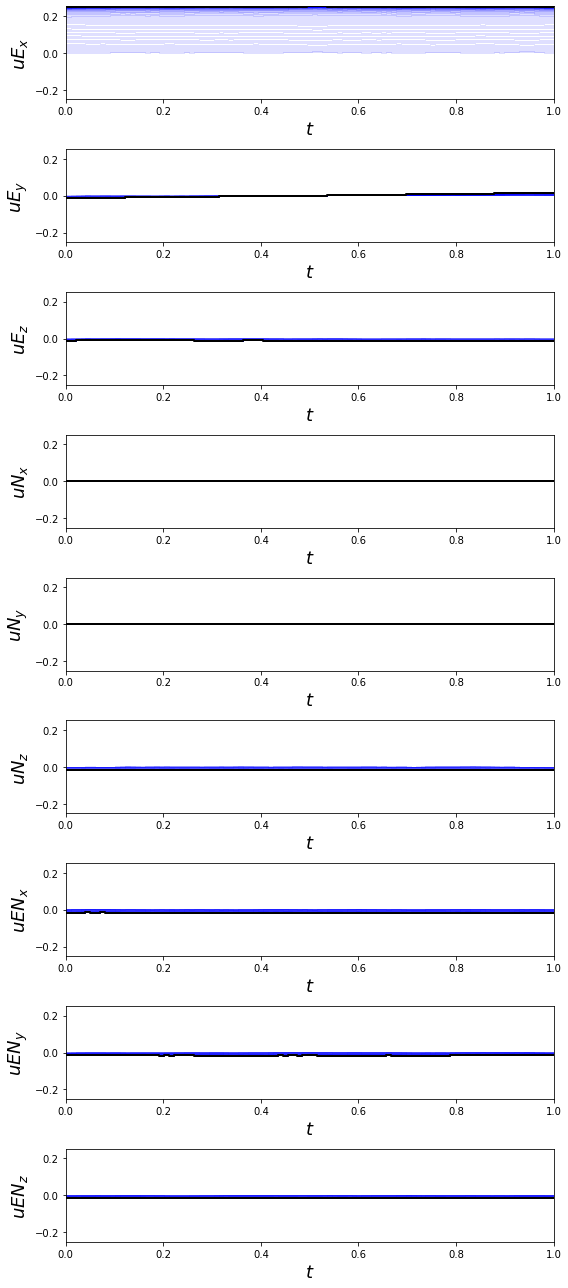

In [30]:
plot_grape_control_fields(times, result.u[:, :, :] / (2 * pi), H_labels, uniform_axes=True);
plt.savefig("NVcenterpluse.jpeg")
plt.show()

# Calcuate fidelity

In [23]:
idealfinalstate=U*startingstate
print (idealfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[ 0.5+0.j        ]
 [ 0. +0.j        ]
 [ 0. +0.j        ]
 [ 0. -0.70710678j]
 [ 0. +0.j        ]
 [ 0. +0.j        ]
 [-0.5+0.j        ]
 [ 0. +0.j        ]
 [ 0. +0.j        ]]


In [24]:
result.U_f.tidyup(1e-2)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = False
Qobj data =
[[ 0.49723336-0.04925554j  0.        +0.j          0.        +0.j
  -0.01193487-0.70740688j  0.        +0.j          0.        +0.j
  -0.49945962+0.01749323j  0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.49967426+0.j          0.        +0.j
   0.        +0.j          0.05888796-0.70503533j  0.        +0.j
   0.        +0.j         -0.49872294-0.03252386j  0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.49727548-0.0489919j
   0.        +0.j          0.        +0.j         -0.01164968-0.70737724j
   0.        +0.j          0.        +0.j         -0.49949686+0.01736218j]
 [-0.01186211-0.70741807j  0.        +0.j          0.        +0.j
   0.        +0.03175235j  0.        +0.j          0.        +0.j
  -0.01173898-0.70588447j  0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.05886849-0.70504737j  0.        +0.j


In [25]:
realfinalstate=result.U_f*startingstate
print (realfinalstate)

Quantum object: dims = [[9], [1]], shape = (9, 1), type = ket
Qobj data =
[[ 0.49723336-0.04925554j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.01186211-0.70741807j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]
 [-0.49945009+0.01736087j]
 [ 0.        +0.j        ]
 [ 0.        +0.j        ]]


In [26]:
idealdensitymatrix=(idealfinalstate * idealfinalstate.dag())#ideal density matrix
densitymatrix=(realfinalstate * realfinalstate.dag())# real density matrix
print (idealdensitymatrix)
print (densitymatrix)
fidelity(idealdensitymatrix,densitymatrix)

Quantum object: dims = [[9], [9]], shape = (9, 9), type = oper, isherm = True
Qobj data =
[[ 0.25+0.j          0.  +0.j          0.  +0.j          0.  +0.35355339j
   0.  +0.j          0.  +0.j         -0.25+0.j          0.  +0.j
   0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j        ]
 [ 0.  -0.35355339j  0.  +0.j          0.  +0.j          0.5 +0.j
   0.  +0.j          0.  +0.j          0.  +0.35355339j  0.  +0.j
   0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j        ]
 [ 0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.  +0.j          0.  +0.j          0.  +0.j          0.  +0.j
   0.

0.9994319870197814

# Plotting City Scape


In [29]:
#plotting cityscape for real density matrix
dm=np.array(densitymatrix)
print (dm)
plot_state_city(dm, title='State Tomography for Real State')

[[ 0.24966712+0.j          0.        +0.j          0.        +0.j
   0.02894602+0.35233613j  0.        +0.j          0.        +0.j
  -0.24919837+0.01596828j  0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j        ]
 [ 0.02894602-0.35233613j  0.        +0.j          0.        +0.j
   0.50058103+0.j          0.        +0.j          0.        +0.j
  -0.00635686+0.35352596j  0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.j          0.        +0.j
   0.        +0.j          0.        +0.

VisualizationError: 'Input is not a multi-qubit quantum state.'

In [39]:
#plotting cityscape for ideal density matrix
idm=np.array(idealdensitymatrix)
print (idm)
plot_state_city(idm, title='State Tomography for Ideal State')

[[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


VisualizationError: 'Input is not a multi-qubit quantum state.'